## Install and Import Libraries 

In [32]:
!pip install datasets &>> install.log
!pip install pyarrow==8.0.0

from matplotlib import pyplot as plt
import IPython.display as ipd
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np

  Using cached pyarrow-8.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
Using cached pyarrow-8.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.4 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
    Uninstalling pyarrow-17.0.0:
      Successfully uninstalled pyarrow-17.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.3 which is incompatible.
datasets 2.20.0 requires pyarrow>=15.0.0, but you have pyarrow 8.0.0 which is incompatible.


## load Cifar10 dataset

In [33]:
cifar10 = load_dataset('cifar10')
print(cifar10.shape)

{'train': (50000, 2), 'test': (10000, 2)}


### Here's an example of adding noise to an image using 100 steps while varying the beta value

In [40]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

In [41]:

def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [42]:
t = torch.tensor(10, dtype=torch.long)
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha_bar = 1. - beta
alpha_bar = torch.cumprod(alpha_bar, dim=0)

In [43]:
def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0 # now alpha_bar
  var = 1-gather(alpha_bar, t) # (1-alpha_bar)
  eps = torch.randn_like(x0)
  return mean + (var ** 0.5) * eps

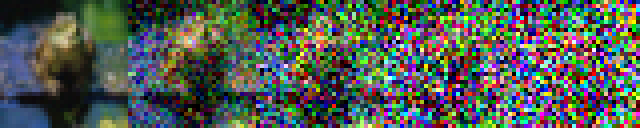

In [44]:
ims = []
start_im = cifar10['train'][100]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

## UNET Model Code

In [45]:
#@title Unet Definition

import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# A fancy activation function
class Swish(nn.Module):
    """
    ### Swish actiavation function
    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: 32):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # [same as those from the transformer](../../transformers/positional_encoding.html)
        #
        # \begin{align}
        # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
        # \end{align}
        #
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

## Final Model Architecture 

In [48]:
x = torch.randn(10, 3, 32, 32)
t = torch.tensor([50.], dtype=torch.long)
unet = UNet()

model_output = unet(x, t)
model_output.shape



torch.Size([10, 3, 32, 32])

In [49]:
from torch.utils.data import DataLoader, Subset

In [50]:

def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0
  var = 1-gather(alpha_bar, t)
  eps = torch.randn_like(x0).to(x0.device)
  return mean + (var ** 0.5) * eps


In [ ]:
def model(lr,n_step,beta,n):
    unet = UNet(n_channels=32)

    lr = lr  # lr change
    n_steps = n_step # n_step change
       # beta change
    alpha = 1. - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    batch_size = 128


    losses = []

    dataset = cifar10['train']
    optim = torch.optim.AdamW(unet.parameters(), lr=lr)

    for i in tqdm(range(0, len(dataset)-batch_size, batch_size)):
      ims = [dataset[idx]['img'] for idx in range(i,i+batch_size)]
      tims = [img_to_tensor(im) for im in ims]
      x0 = torch.cat(tims)
      t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long)
      xt, noise = q_xt_x0(x0, t)
      pred_noise = unet(xt.float(), t)
      loss = F.mse_loss(noise.float(), pred_noise)
      losses.append(loss.item())
      optim.zero_grad()
      loss.backward()
      optim.step()
    torch.save(unet, f"/kaggle/working/unet_model2{n}a.pth")
    plt.plot(losses)

In [16]:
def p_xt(xt, noise, t):
  alpha_t = gather(alpha, t)
  alpha_bar_t = gather(alpha_bar, t)
  eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
  mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise) # Note minus sign
  var = gather(beta, t)
  eps = torch.randn(xt.shape, device=xt.device)
  return mean + (var ** 0.5) * eps

### results with 2 sets of hyperparameters 
varying learning rate, noising schedule (beta), number of denoising steps.

 I downloaded both model in .pth file they take around 2-3hr so i just put graph that i generated before

## 1

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.02, n_steps)
lr = 1e-4
n=1
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
model(lr,n_steps,beta,n)

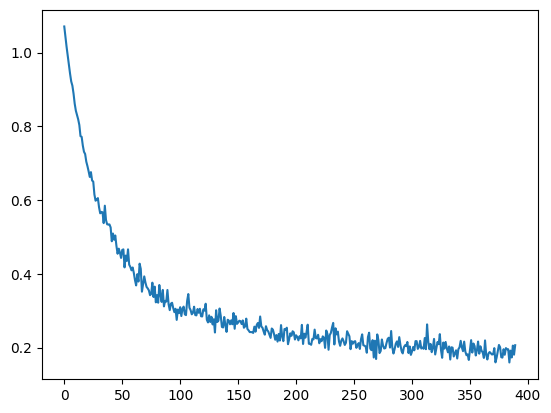

## 2

In [ ]:
n_steps = 200
beta = torch.linspace(0.0001, 0.02, n_steps)
lr = 4e-4

n=2
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
model(lr,n_steps,beta,n)

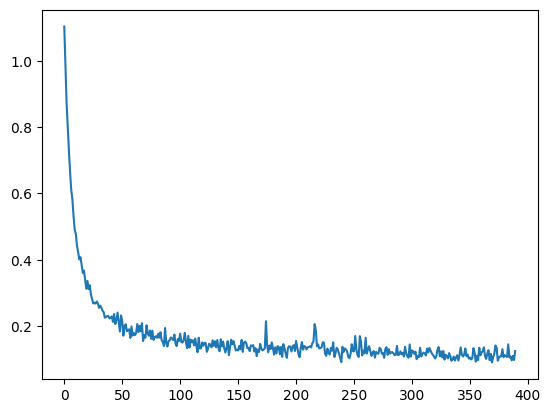

### One sample from each class (10 classes) in the CIFAR-10 dataset

### Model 1

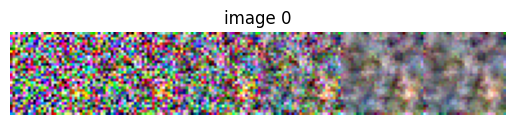

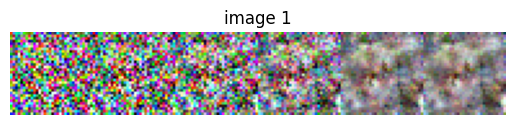

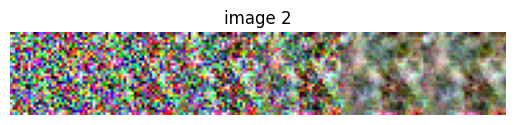

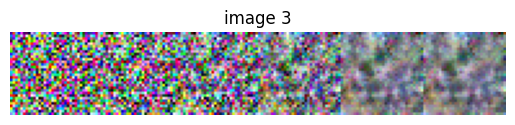

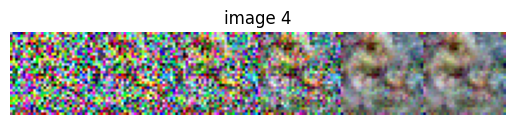

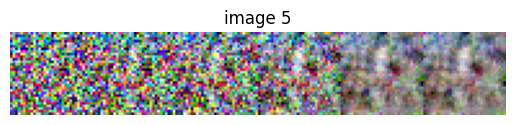

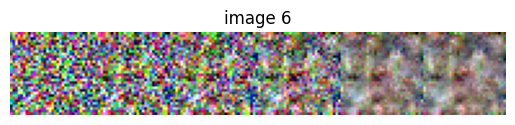

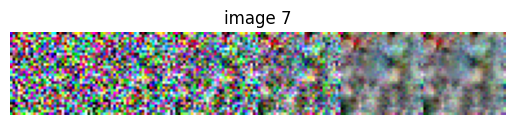

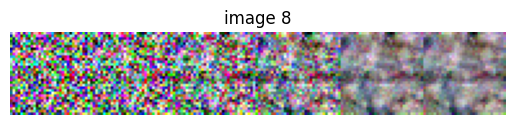

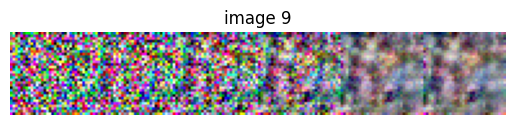

In [55]:
n_steps = 100
beta = torch.linspace(0.0001, 0.02, n_steps)
lr = 1e-4
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
n=1
nn=2
unet1 = torch.load(f"/kaggle/input/unet_model21a/pytorch/default/1/unet_model21a.pth")
unet1.eval()
for v in range(10):
    x = torch.randn(1, 3, 32, 32)
    ims = []
    for i in range(n_steps):
      t = torch.tensor(n_steps-i-1, dtype=torch.long)
      with torch.no_grad():
        pred_noise = unet1(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
        if i%24 == 0 or i == 99:
          ims.append(tensor_to_image(x))

    image = Image.new('RGB', size=(32*6, 32))
    for i, im in enumerate(ims[:6]):
      image.paste(im, ((i%6)*32, 0))
    image.resize((32*4*6, 32*4), Image.NEAREST)
    image = image.convert("RGB")

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')

    plt.title(f"image {v}")# Hide axes
    plt.show()

### Model 2

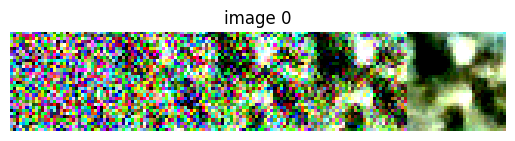

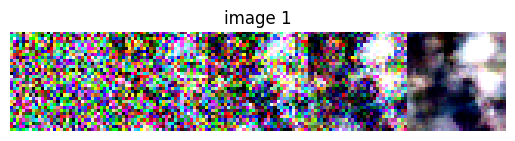

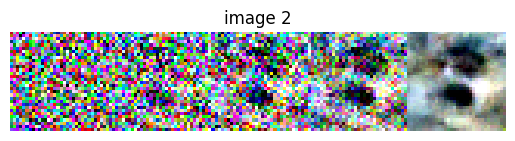

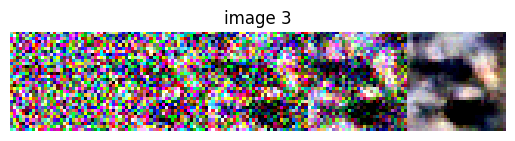

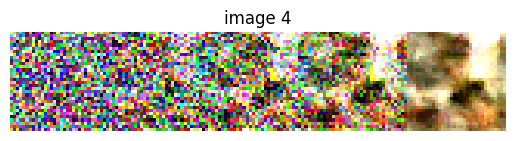

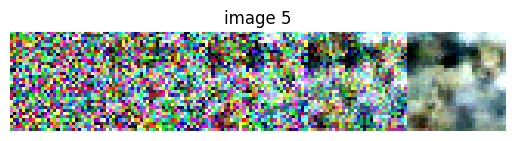

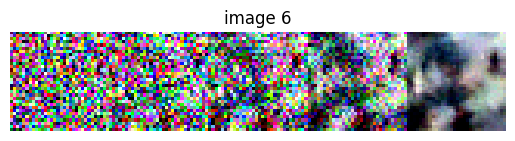

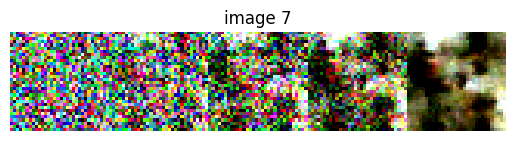

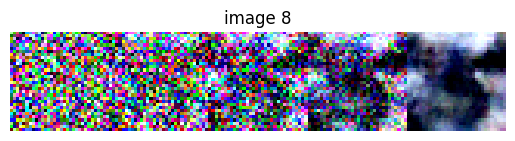

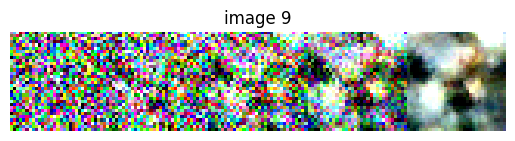

In [53]:
n_steps = 200
beta = torch.linspace(0.0001, 0.04, n_steps)
lr = 4e-4
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
n=1
nn=2
unet2 = torch.load(f"/kaggle/input/unet_model22a/pytorch/default/1/unet_model22a.pth")
unet2.eval()
for v in range(10):
    x = torch.randn(1, 3, 32, 32)
    ims = []
    for i in range(n_steps):
      t = torch.tensor(n_steps-i-1, dtype=torch.long)
      with torch.no_grad():
        pred_noise = unet2(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
        if i%49 == 0:
          ims.append(tensor_to_image(x))

    image = Image.new('RGB', size=(32*5, 32))
    for p, im in enumerate(ims[:5]):
      image.paste(im, ((p%5)*32, 0))
    image.resize((32*4*5, 32*4), Image.NEAREST)
    image = image.convert("RGB")

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')

    plt.title(f"image {v}")# Hide axes
    plt.show()

n = 100 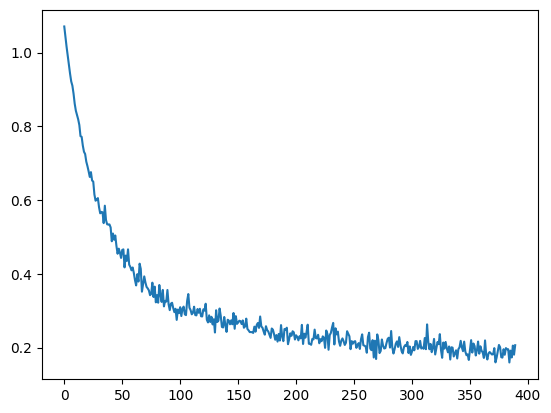 n = 200 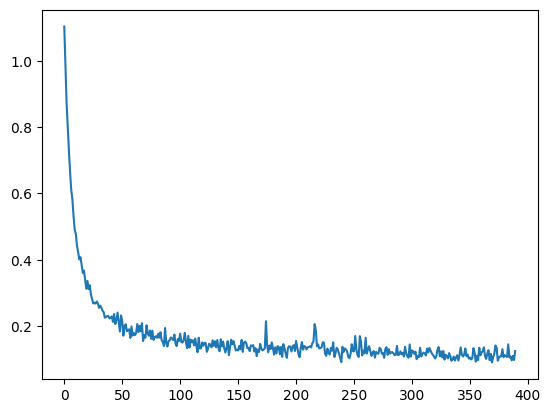
> 

## First Model:

### n_steps = 100,beta = torch.linspace(0.0001, 0.02, 100),lr = 1e-4

### The loss curve shows a rapid initial decrease followed by a more gradual decline, indicating effective initial learning and gradual fine-tuning. The fluctuations observed in the later stages suggest that while the model is generally converging, it still encounters some variability in the denoising process.

## Second Model:

### n_steps = 200,beta = torch.linspace(0.0001, 0.04, 100),lr = 4e-4


### The loss curve for the second model follows a similar trend to the first but extends over a longer period due to the increased number of steps. The overall lower and more stable loss in the latter part of the curve indicates a more refined denoising process, attributed to the higher number of steps and increased beta range. The higher learning rate helps maintain a reasonable training time despite the increased complexity.

## Conclusion:

### The choice of parameters for both models reflects a balance between computational efficiency and the quality of the denoising process. The first model, with fewer steps and a smaller beta range, provides a quicker but slightly less refined denoising process. The second model, with more steps and a higher beta range, offers a more granular and potentially higher quality denoising at the cost of increased computation. The observations generally align with the expectations, with the second model showing more stable and lower losses in the long run, validating the effectiveness of the chosen parameters.

In [17]:
num_images = len(cifar10['train'][:]['img'])
random_index = torch.randint(0, num_images, (1,)).item()

# B) partial Noise

## Instead of starting with complete Gaussian Noise, started with a partially noised sample (noisy sample) and denoised it.

1. 5 iterations
2. 10 iterations
3. 50 iterations
4. 99 iterations (Gaussian Noise)



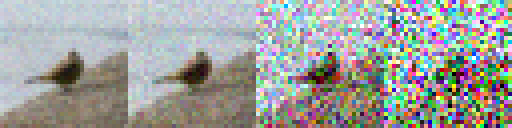

In [62]:
beta = torch.linspace(0.0001, 0.02, 200)
lr = 4e-4
n_step = 200
n=2

imsw = []
start_im = cifar10['train'][random_index]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [5,10,50,99]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  imsw.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*4, 32))
for i, imd in enumerate(imsw):
  image.paste(imd, ((i%4)*32, 0))
image.resize((32*4*4, 32*4), Image.NEAREST)

## Denoised the sample

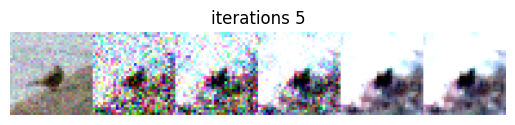

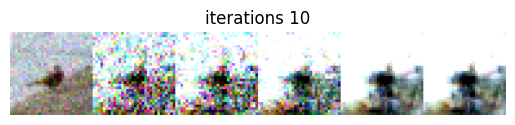

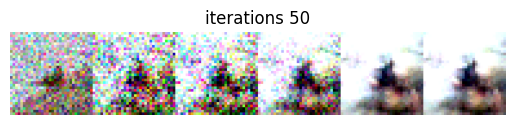

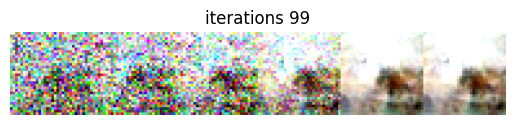

In [63]:
from PIL import Image
import matplotlib.pyplot as plt
n_steps = 200
lr = 4e-4
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
n=1
nn=2
unet2 = torch.load(f"/kaggle/input/unet_model22a/pytorch/default/1/unet_model22a.pth")
unet2.eval()
tm = [5,10,50,99]
for g in imsw:
    start_im = g
    x = img_to_tensor(start_im)
    ims = []
    for i in range(n_steps):
      t = torch.tensor(n_steps-i-1, dtype=torch.long)
      with torch.no_grad():
        pred_noise = unet2(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
        if i%49  == 0 or i == 199 :
          ims.append(tensor_to_image(x))


    image = Image.new('RGB', size=(32*6, 32))
    for i, im in enumerate(ims[:7]):
      image.paste(im, ((i%6)*32, 0))
    image = image.resize((32*4*6, 32*4), Image.NEAREST)
    image = image.convert("RGB")

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')

    plt.title(f"iterations {tm[imsw.index(g)]}")# Hide axes
    plt.show()

## The denoised images after 5 and 10 iterations show noticeable improvement compared to those after 50 iterations, where the noise becomes more prominent. Although the image after 99 iterations is not as clear overall, the background surrounding the object appears cleaner and more defined.